<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/target_preprocessing/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Packages

In [13]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 2
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

## Functions

In [3]:
def report_model(model, X, Y):
    preds = model.predict(X)
    print(mean_squared_error(y_true=Y, y_pred=preds, squared=False))

# Download the data

In [4]:
df_train = pd.read_csv(f'{manager.data_trial_path}/train_processed.csv', index_col=0)
df_val = pd.read_csv(f'{manager.data_trial_path}/val_processed.csv', index_col=0)
df_test = pd.read_csv(f'{manager.data_trial_path}/test_processed.csv', index_col=0)
df_submission = pd.read_csv(f'{manager.data_trial_path}/submission_processed.csv', index_col=0)

In [5]:
# I forgot to re-insert the original index of submission dataset
submission_index = pd.read_csv(f'{manager.data_root_path}/sample_submission.csv', index_col='id').index

In [7]:
X_train = df_train.iloc[:, :-1]
Y_train = df_train.iloc[:, -1]
X_train.max().max()

1.0000000000000002

In [8]:
X_val = df_val.iloc[:, :-1]
Y_val = df_val.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
Y_test = df_test.iloc[:, -1]

X_submission = df_submission.iloc[:, :]

X_trainval = np.vstack([X_train, X_val])
Y_trainval = np.concatenate([Y_train, Y_val])

In [9]:
Xs = [
    X_train,
    X_val,
    X_test,
    X_submission
]

Ys = [
    Y_train,
    Y_val,
    Y_test,
    None
]

# Find the baseline model

## Random forest regressor

In [76]:
from sklearn.ensemble import RandomForestRegressor
from model import Model

RandomForestModel = Model(
    RandomForestRegressor(n_estimators=80),
    'RF',
    [
        {
            'n_estimators': [200],
            # 'max_depth': [None, 10, df_train.shape[1] // 2]
            # other params
        },
    ],
    [
        {
            # Randomized search CV params grid
        },

    ]
)

In [77]:
all_models = {
    model.name: model
    for model in [
        RandomForestModel,
    ]
}

### RandomizedSearchCV

In [69]:
from sklearn.model_selection import RandomizedSearchCV

rfr_randomized = RandomizedSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators': np.arange(10, 200),
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'max_depth': np.arange(2, df_train.shape[1]),
        'min_samples_split': np.linspace(0.01, 0.99, 10),
        'max_features': ['sqrt', 'log2'],
        'random_state': np.arange(100),
        'warm_start': [True, False]
    },
    cv=3,
    n_iter=10,
    scoring='neg_mean_squared_error',
    verbose=5
)

In [70]:
rft_randomized_res = rfr_randomized.fit(
    X_train,
    Y_train,
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=squared_error, max_depth=6, max_features=sqrt, min_samples_split=0.01, n_estimators=11, random_state=33, warm_start=False;, score=-2330549468056.471 total time=   0.4s
[CV 2/5] END criterion=squared_error, max_depth=6, max_features=sqrt, min_samples_split=0.01, n_estimators=11, random_state=33, warm_start=False;, score=-3309789604718.128 total time=   0.2s
[CV 3/5] END criterion=squared_error, max_depth=6, max_features=sqrt, min_samples_split=0.01, n_estimators=11, random_state=33, warm_start=False;, score=-3173918916637.939 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=6, max_features=sqrt, min_samples_split=0.01, n_estimators=11, random_state=33, warm_start=False;, score=-2231542343763.723 total time=   0.2s
[CV 5/5] END criterion=squared_error, max_depth=6, max_features=sqrt, min_samples_split=0.01, n_estimators=11, random_state=33, warm_start=False;, score=-2964393919404.471 tot

KeyboardInterrupt: ignored

In [ ]:
report_model(rft_randomized_res.best_estimator_, X_train, Y_train)
report_model(rft_randomized_res.best_estimator_, X_val, Y_val)

### GridSearchCV

Fitting RF
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END n_estimators=200;, score=(train=-17283197.361, test=-69147731.928) total time=  13.3s
[CV 2/2] END n_estimators=200;, score=(train=-9047498.173, test=-112483752.729) total time=  12.5s


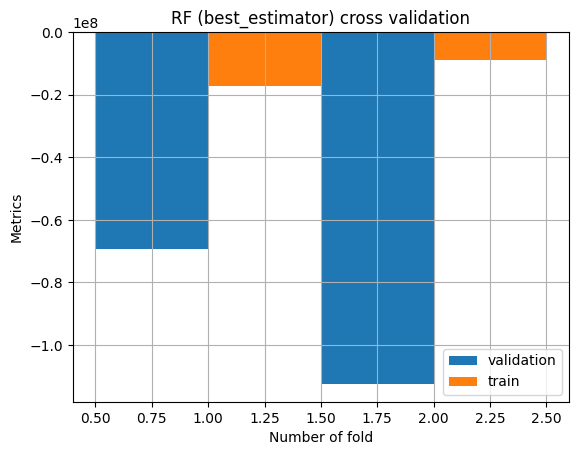

In [91]:
from sklearn_utils import dict_subset
from sklearn_utils import (
    fit_grid_search,
    fit_randomized_search
)

rf_gridsearch_results = fit_grid_search(
    dict_subset(all_models, ['RF']),
    X_=X_train,  # X_trainval,
    Y_=Y_train,  # Y_trainval,
    cv_=2,
    scoring_='neg_mean_squared_error',
    verbose=3,
    to_put_minus=True
)

In [92]:
report_model(rf_gridsearch_results['RF'].best_estimator_, X_train, Y_train)
report_model(rf_gridsearch_results['RF'].best_estimator_, X_val, Y_val)

3648.6598115769893
9998.503683088782


In [85]:
rf_gridsearch_results['RF'].best_params_

{'n_estimators': 200}

## SVM

In [18]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, Y_train)

SVR()

In [19]:
report_model(svr, X_train, Y_train)

2935719.573051039


## Linear regression

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [21]:
report_model(lin_reg, X_train, Y_train)
report_model(lin_reg, X_val, Y_val)

9400.071852845205
10618.677414472577


In [ ]:
report_model(lin_reg, X_train, Y_train)
report_model(lin_reg, X_val, Y_val)

9399.839416176697
10619.012527092338


## Elastic net

### RandomizedSearchCV

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet


elastic_net_randomized = RandomizedSearchCV(
    ElasticNet(),
    param_distributions={
        'alpha': np.linspace(0, 1.0, num=15),
        'l1_ratio': np.linspace(0, 1.0, num=15),
        'warm_start': [False, True],
        'random_state': np.arange(1000)
    },
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
)

In [87]:
elastic_net_randomized_res = elastic_net_randomized.fit(
    X_train,
    Y_train
)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.776e+16, tolerance: 8.607e+12 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.745e+16, tolerance: 8.525e+12 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

In [88]:
report_model(elastic_net_randomized_res.best_estimator_, X_train, Y_train), \
    elastic_net_randomized_res.best_estimator_, \
    report_model(elastic_net_randomized_res.best_estimator_, X_val, Y_val)

9400.092574169268
10617.980993893025


(None,
 ElasticNet(alpha=0.5, l1_ratio=1.0, random_state=255, warm_start=True),
 None)

# Save the models

In [93]:
manager.save_models({
    'RF': rf_gridsearch_results['RF'].best_estimator_,
    'ElasticNet': elastic_net_randomized_res.best_estimator_
})

# Make predictions with the best model

## Final report

In [48]:
from sklearn.ensemble import RandomForestRegressor


best_model = rf_gridsearch_results['RF'].best_estimator_ # elastic_net_randomized_res.best_estimator_ # RandomForestRegressor(n_estimators=100)
best_model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200)

In [49]:
from sklearn.metrics import mean_squared_error

report_model(best_model, X_train, Y_train)
report_model(best_model, X_val, Y_val)

3727.975166981364
10706.419024578174


## Retrain on all available data

In [50]:
best_model.fit(
    np.vstack([X_train, X_val, X_test]),
    np.concatenate([Y_train, Y_val, Y_test])
)

RandomForestRegressor(n_estimators=200)

# Predict and save predictions

In [51]:
submission_preds = best_model.predict(X_submission)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [52]:
submission_df = pd.DataFrame(
    {
        'price': submission_preds
    },
    index=submission_index
)
submission_df.head()

,price
id,
22730,4.766993e+06
22731,6.218868e+06
22732,9.068749e+06
22733,1.645013e+06
22734,6.759304e+06


In [53]:
submission_df.to_csv(
    f'{manager.data_trial_path}/rfr_20_10_23.csv',
    index=True
)